In [1]:
from __future__ import annotations

from typing import Any

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display as ipy_display

import torch
import transformers
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from transformers import Trainer
from transformers import TrainingArguments
from transformers.trainer_utils import EvalPrediction

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}", end="\n\n")
print(f"Torch version: {torch.__version__}")

Using device: cuda

Torch version: 1.13.1+cu116


In [3]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [4]:
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


def compute_metrics(eval_pred: EvalPrediction) -> dict[str, Any]:
    """Compute metrics for the model."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='macro'),
        'recall': recall_score(labels, predictions, average='macro'),
        'f1': f1_score(labels, predictions, average='macro'),
    }

In [5]:
RAW_DATA_FILE = "../../data/reddit_ell_eng_raw_pos.csv"

MARKERS = ['o', 's', 'v', 'p', 'x', 'd', 'h', '8', 'P', '*']
COLORS  = ['#404080', '#a52040', '#7d7dfa', '#d7d7d7', '#ff7f0e',
           '#2ca02c', '#1f77b4', '#9467bd', '#8c564b', '#e377c2']

PARMS = {
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 1e-6,
    'seed': 42,
    'max_length': 512,
}

all_results = pd.DataFrame()

In [6]:
df = pd.read_csv(RAW_DATA_FILE, encoding='utf-8')

df, labels = encode_labels(df, 'label')

X = df['text']
y = df['label']

gss_1 = GroupShuffleSplit(n_splits=5, test_size=0.2)
train_idx, test_idx = next(gss_1.split(X, y, groups=df['user_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

gss_2 = GroupShuffleSplit(n_splits=5, test_size=0.5)
val_idx, test_idx = next(gss_2.split(X_test, y_test, groups=df['user_id'].iloc[test_idx]))
X_val, X_test = X_test.iloc[val_idx], X_test.iloc[test_idx]
y_val, y_test = y_test.iloc[val_idx], y_test.iloc[test_idx]

print(f"{X_train.shape=}, {X_test.shape=}")
print(f"{y_train.shape=}, {y_test.shape=}")
print(f"{X_val.shape=}, {y_val.shape=}", end="\n\n")

X_train.shape=(7880,), X_test.shape=(1106,)
y_train.shape=(7880,), y_test.shape=(1106,)
X_val.shape=(938,), y_val.shape=(938,)



In [7]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = transformers.DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)

train_dataset = RedditDataset(train_encodings, y_train.tolist())
test_dataset = RedditDataset(test_encodings, y_test.tolist())
val_dataset = RedditDataset(val_encodings, y_val.tolist())


# add dropout and early stopping
model.config.dropout = 0.75
early_stopping = transformers.EarlyStoppingCallback(early_stopping_patience=5)

training_args = transformers.TrainingArguments(
    output_dir=f'../results/reports/{model_name}',
    num_train_epochs=PARMS['epochs'],
    learning_rate=PARMS['learning_rate'],
    per_device_train_batch_size=PARMS['batch_size'],
    per_device_eval_batch_size=PARMS['batch_size'],
    evaluation_strategy='epoch',
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs/distilbert',
    logging_steps=len(train_dataset) // PARMS['batch_size'],
    log_level='error',
    disable_tqdm=False,
    seed=PARMS['seed'],
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[early_stopping],
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

  0%|          | 0/12350 [00:00<?, ?it/s]

{'loss': 0.6944, 'learning_rate': 4.92e-07, 'epoch': 1.0}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.6920996904373169, 'eval_accuracy': 0.47761194029850745, 'eval_precision': 0.6304001026844653, 'eval_recall': 0.5687978871604366, 'eval_f1': 0.44778450595924646, 'eval_runtime': 8.4238, 'eval_samples_per_second': 111.351, 'eval_steps_per_second': 3.561, 'epoch': 1.0}
{'loss': 0.6543, 'learning_rate': 9.84e-07, 'epoch': 1.99}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.6215785145759583, 'eval_accuracy': 0.7057569296375267, 'eval_precision': 0.7271109133385248, 'eval_recall': 0.7369979103784536, 'eval_f1': 0.7049184812342707, 'eval_runtime': 8.5528, 'eval_samples_per_second': 109.672, 'eval_steps_per_second': 3.508, 'epoch': 2.0}
{'loss': 0.5155, 'learning_rate': 9.799156118143459e-07, 'epoch': 2.99}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.5143426656723022, 'eval_accuracy': 0.7515991471215352, 'eval_precision': 0.7500716153234057, 'eval_recall': 0.7660252689420324, 'eval_f1': 0.7473956978882412, 'eval_runtime': 9.1249, 'eval_samples_per_second': 102.796, 'eval_steps_per_second': 3.288, 'epoch': 3.0}
{'loss': 0.4432, 'learning_rate': 9.591561181434598e-07, 'epoch': 3.98}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.47233232855796814, 'eval_accuracy': 0.7697228144989339, 'eval_precision': 0.7616792929292929, 'eval_recall': 0.7766862084977944, 'eval_f1': 0.7635128510399887, 'eval_runtime': 8.9493, 'eval_samples_per_second': 104.812, 'eval_steps_per_second': 3.352, 'epoch': 4.0}
{'loss': 0.4167, 'learning_rate': 9.383966244725739e-07, 'epoch': 4.98}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.44817763566970825, 'eval_accuracy': 0.7889125799573561, 'eval_precision': 0.776374477455957, 'eval_recall': 0.7865345174522096, 'eval_f1': 0.779881101376721, 'eval_runtime': 8.4184, 'eval_samples_per_second': 111.423, 'eval_steps_per_second': 3.564, 'epoch': 5.0}
{'loss': 0.3969, 'learning_rate': 9.176371308016877e-07, 'epoch': 5.98}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4518749415874481, 'eval_accuracy': 0.7835820895522388, 'eval_precision': 0.7733490750585712, 'eval_recall': 0.7872600804891263, 'eval_f1': 0.7764975849663421, 'eval_runtime': 8.4111, 'eval_samples_per_second': 111.519, 'eval_steps_per_second': 3.567, 'epoch': 6.0}
{'loss': 0.3852, 'learning_rate': 8.968776371308017e-07, 'epoch': 6.97}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.45836836099624634, 'eval_accuracy': 0.779317697228145, 'eval_precision': 0.7708313297704261, 'eval_recall': 0.7860604829347574, 'eval_f1': 0.7731225878369141, 'eval_runtime': 8.416, 'eval_samples_per_second': 111.454, 'eval_steps_per_second': 3.565, 'epoch': 7.0}
{'loss': 0.3725, 'learning_rate': 8.761181434599155e-07, 'epoch': 7.97}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4476701021194458, 'eval_accuracy': 0.7878464818763327, 'eval_precision': 0.7776665423898885, 'eval_recall': 0.7917972680133116, 'eval_f1': 0.7809015734399117, 'eval_runtime': 8.6312, 'eval_samples_per_second': 108.675, 'eval_steps_per_second': 3.476, 'epoch': 8.0}
{'loss': 0.3621, 'learning_rate': 8.553586497890295e-07, 'epoch': 8.96}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.44599735736846924, 'eval_accuracy': 0.7899786780383795, 'eval_precision': 0.7798252760555471, 'eval_recall': 0.7940658617754044, 'eval_f1': 0.7831035676766965, 'eval_runtime': 8.3151, 'eval_samples_per_second': 112.807, 'eval_steps_per_second': 3.608, 'epoch': 9.0}
{'loss': 0.357, 'learning_rate': 8.345991561181434e-07, 'epoch': 9.96}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.45154857635498047, 'eval_accuracy': 0.7867803837953091, 'eval_precision': 0.777572314808017, 'eval_recall': 0.7926098986146584, 'eval_f1': 0.7803906143912044, 'eval_runtime': 8.3502, 'eval_samples_per_second': 112.333, 'eval_steps_per_second': 3.593, 'epoch': 10.0}
{'loss': 0.3451, 'learning_rate': 8.138396624472574e-07, 'epoch': 10.96}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4528975188732147, 'eval_accuracy': 0.7921108742004265, 'eval_precision': 0.7825225009992787, 'eval_recall': 0.797446985527436, 'eval_f1': 0.7856376900764701, 'eval_runtime': 8.3407, 'eval_samples_per_second': 112.461, 'eval_steps_per_second': 3.597, 'epoch': 11.0}
{'loss': 0.3391, 'learning_rate': 7.930801687763713e-07, 'epoch': 11.95}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4234865605831146, 'eval_accuracy': 0.8017057569296375, 'eval_precision': 0.7892616507580011, 'eval_recall': 0.799033550034827, 'eval_f1': 0.792844522968198, 'eval_runtime': 8.3377, 'eval_samples_per_second': 112.5, 'eval_steps_per_second': 3.598, 'epoch': 12.0}
{'loss': 0.3315, 'learning_rate': 7.723206751054852e-07, 'epoch': 12.95}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.46104443073272705, 'eval_accuracy': 0.7931769722814499, 'eval_precision': 0.7846344145134689, 'eval_recall': 0.8005282098908753, 'eval_f1': 0.7872936313862641, 'eval_runtime': 8.3992, 'eval_samples_per_second': 111.678, 'eval_steps_per_second': 3.572, 'epoch': 13.0}
{'loss': 0.3312, 'learning_rate': 7.515611814345991e-07, 'epoch': 13.94}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.44096100330352783, 'eval_accuracy': 0.8049040511727079, 'eval_precision': 0.7938315819671753, 'eval_recall': 0.8071646931352062, 'eval_f1': 0.7977006888505213, 'eval_runtime': 8.3348, 'eval_samples_per_second': 112.54, 'eval_steps_per_second': 3.599, 'epoch': 14.0}
{'loss': 0.32, 'learning_rate': 7.308016877637131e-07, 'epoch': 14.94}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.44271719455718994, 'eval_accuracy': 0.8059701492537313, 'eval_precision': 0.7946378907553677, 'eval_recall': 0.8074645925237984, 'eval_f1': 0.7985518807142419, 'eval_runtime': 8.309, 'eval_samples_per_second': 112.89, 'eval_steps_per_second': 3.611, 'epoch': 15.0}
{'loss': 0.314, 'learning_rate': 7.100421940928269e-07, 'epoch': 15.94}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4615950286388397, 'eval_accuracy': 0.7995735607675906, 'eval_precision': 0.789929214929215, 'eval_recall': 0.8051089311972757, 'eval_f1': 0.7932535160408372, 'eval_runtime': 8.3477, 'eval_samples_per_second': 112.366, 'eval_steps_per_second': 3.594, 'epoch': 16.0}
{'loss': 0.3019, 'learning_rate': 6.892827004219409e-07, 'epoch': 16.93}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4550986588001251, 'eval_accuracy': 0.7985074626865671, 'eval_precision': 0.788212121910203, 'eval_recall': 0.8025839718288058, 'eval_f1': 0.7917472802816454, 'eval_runtime': 8.3546, 'eval_samples_per_second': 112.274, 'eval_steps_per_second': 3.591, 'epoch': 17.0}
{'loss': 0.3003, 'learning_rate': 6.685232067510547e-07, 'epoch': 17.93}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4654964506626129, 'eval_accuracy': 0.8006396588486141, 'eval_precision': 0.791141566777085, 'eval_recall': 0.8065213605758068, 'eval_f1': 0.79443204125282, 'eval_runtime': 8.4205, 'eval_samples_per_second': 111.395, 'eval_steps_per_second': 3.563, 'epoch': 18.0}
{'loss': 0.2875, 'learning_rate': 6.477637130801688e-07, 'epoch': 18.92}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4672155976295471, 'eval_accuracy': 0.7985074626865671, 'eval_precision': 0.7887184368691398, 'eval_recall': 0.8036965018187446, 'eval_f1': 0.7920735991105055, 'eval_runtime': 8.3456, 'eval_samples_per_second': 112.395, 'eval_steps_per_second': 3.595, 'epoch': 19.0}
{'loss': 0.2853, 'learning_rate': 6.270042194092828e-07, 'epoch': 19.92}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4490821063518524, 'eval_accuracy': 0.8091684434968017, 'eval_precision': 0.7978131304932632, 'eval_recall': 0.8105893506694528, 'eval_f1': 0.8017880184114189, 'eval_runtime': 8.3876, 'eval_samples_per_second': 111.832, 'eval_steps_per_second': 3.577, 'epoch': 20.0}
{'loss': 0.2833, 'learning_rate': 6.062447257383966e-07, 'epoch': 20.91}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.48647305369377136, 'eval_accuracy': 0.7974413646055437, 'eval_precision': 0.7889316474253252, 'eval_recall': 0.8050653974150608, 'eval_f1': 0.7916793297081968, 'eval_runtime': 8.4432, 'eval_samples_per_second': 111.095, 'eval_steps_per_second': 3.553, 'epoch': 21.0}
{'loss': 0.2694, 'learning_rate': 5.854852320675106e-07, 'epoch': 21.91}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4548293650150299, 'eval_accuracy': 0.8102345415778252, 'eval_precision': 0.7986617100371747, 'eval_recall': 0.8108892500580451, 'eval_f1': 0.8026402265753179, 'eval_runtime': 8.3978, 'eval_samples_per_second': 111.696, 'eval_steps_per_second': 3.572, 'epoch': 22.0}
{'loss': 0.2736, 'learning_rate': 5.647257383966244e-07, 'epoch': 22.91}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.47590118646621704, 'eval_accuracy': 0.8070362473347548, 'eval_precision': 0.7966263115415657, 'eval_recall': 0.8111020818822072, 'eval_f1': 0.8004027730915597, 'eval_runtime': 8.4157, 'eval_samples_per_second': 111.458, 'eval_steps_per_second': 3.565, 'epoch': 23.0}
{'loss': 0.256, 'learning_rate': 5.439662447257384e-07, 'epoch': 23.9}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4685038626194, 'eval_accuracy': 0.8091684434968017, 'eval_precision': 0.7985729257561278, 'eval_recall': 0.8128144106493305, 'eval_f1': 0.8024484801421319, 'eval_runtime': 8.4171, 'eval_samples_per_second': 111.44, 'eval_steps_per_second': 3.564, 'epoch': 24.0}
{'loss': 0.2624, 'learning_rate': 5.232067510548523e-07, 'epoch': 24.9}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.474333792924881, 'eval_accuracy': 0.8102345415778252, 'eval_precision': 0.7995519216555802, 'eval_recall': 0.8136705750328922, 'eval_f1': 0.8034718821801198, 'eval_runtime': 8.4008, 'eval_samples_per_second': 111.656, 'eval_steps_per_second': 3.571, 'epoch': 25.0}
{'loss': 0.2527, 'learning_rate': 5.024472573839662e-07, 'epoch': 25.89}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4640273153781891, 'eval_accuracy': 0.8134328358208955, 'eval_precision': 0.8021636789499316, 'eval_recall': 0.8151265381936383, 'eval_f1': 0.8062173364357448, 'eval_runtime': 8.4852, 'eval_samples_per_second': 110.545, 'eval_steps_per_second': 3.536, 'epoch': 26.0}
{'loss': 0.2497, 'learning_rate': 4.816877637130801e-07, 'epoch': 26.89}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.4933778941631317, 'eval_accuracy': 0.8113006396588486, 'eval_precision': 0.8011771752401575, 'eval_recall': 0.816195534401362, 'eval_f1': 0.804969675184398, 'eval_runtime': 8.4761, 'eval_samples_per_second': 110.664, 'eval_steps_per_second': 3.539, 'epoch': 27.0}
{'loss': 0.2486, 'learning_rate': 4.609282700421941e-07, 'epoch': 27.89}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.49514710903167725, 'eval_accuracy': 0.8070362473347548, 'eval_precision': 0.7966263115415657, 'eval_recall': 0.8111020818822072, 'eval_f1': 0.8004027730915597, 'eval_runtime': 8.3646, 'eval_samples_per_second': 112.139, 'eval_steps_per_second': 3.587, 'epoch': 28.0}
{'loss': 0.2354, 'learning_rate': 4.40168776371308e-07, 'epoch': 28.88}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.509196400642395, 'eval_accuracy': 0.8091684434968017, 'eval_precision': 0.8000298377286603, 'eval_recall': 0.8161520006191472, 'eval_f1': 0.8033757142037397, 'eval_runtime': 8.5474, 'eval_samples_per_second': 109.741, 'eval_steps_per_second': 3.51, 'epoch': 29.0}
{'loss': 0.2462, 'learning_rate': 4.1940928270042193e-07, 'epoch': 29.88}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.5079668164253235, 'eval_accuracy': 0.802771855010661, 'eval_precision': 0.7935711170786568, 'eval_recall': 0.8093462193328689, 'eval_f1': 0.7967849560206248, 'eval_runtime': 8.373, 'eval_samples_per_second': 112.027, 'eval_steps_per_second': 3.583, 'epoch': 30.0}
{'loss': 0.2326, 'learning_rate': 3.9864978902953584e-07, 'epoch': 30.87}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.5028963685035706, 'eval_accuracy': 0.8081023454157783, 'eval_precision': 0.798053897730622, 'eval_recall': 0.8130707762557078, 'eval_f1': 0.8017425612362321, 'eval_runtime': 8.3648, 'eval_samples_per_second': 112.137, 'eval_steps_per_second': 3.586, 'epoch': 31.0}
{'train_runtime': 6339.8019, 'train_samples_per_second': 62.147, 'train_steps_per_second': 1.948, 'train_loss': 0.3402085435037064, 'epoch': 31.0}


TrainOutput(global_step=7657, training_loss=0.3402085435037064, metrics={'train_runtime': 6339.8019, 'train_samples_per_second': 62.147, 'train_steps_per_second': 1.948, 'train_loss': 0.3402085435037064, 'epoch': 31.0})

In [8]:
trainer.evaluate()
trainer.state.save_to_json(f'../results/reports/{model_name}/trainer_state.json')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

y_pred_metrics:


,test_loss,test_accuracy,test_precision,test_recall,test_f1,test_runtime,test_samples_per_second,test_steps_per_second
0,0.453134,0.819168,0.791715,0.80446,0.797202,8.7619,126.228,3.995


Log history:


,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.6944,4.920000e-07,1.00,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.00,247,0.692100,0.477612,0.630400,0.568798,0.447785,8.4238,111.351,3.561,NaN,NaN,NaN,NaN,NaN
2,0.6543,9.840000e-07,1.99,492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.00,494,0.621579,0.705757,0.727111,0.736998,0.704918,8.5528,109.672,3.508,NaN,NaN,NaN,NaN,NaN
4,0.5155,9.799156e-07,2.99,738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,NaN,NaN,30.00,7410,0.507967,0.802772,0.793571,0.809346,0.796785,8.3730,112.027,3.583,NaN,NaN,NaN,NaN,NaN
60,0.2326,3.986498e-07,30.87,7626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,31.00,7657,0.502896,0.808102,0.798054,0.813071,0.801743,8.3648,112.137,3.586,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,31.00,7657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6339.8019,62.147,1.948,3.235914e+16,0.340209


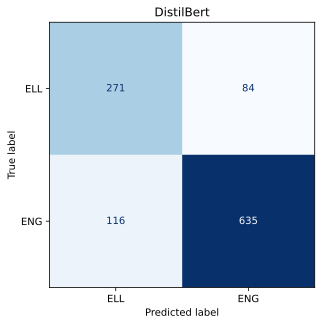

              precision    recall  f1-score   support

         ELL       0.70      0.76      0.73       355
         ENG       0.88      0.85      0.86       751

    accuracy                           0.82      1106
   macro avg       0.79      0.80      0.80      1106
weighted avg       0.82      0.82      0.82      1106



,precision,recall,f1-score,support,maxlen
ELL,0.700258,0.763380,0.730458,355.000000,none
ENG,0.883171,0.845539,0.863946,751.000000,none
accuracy,0.819168,0.819168,0.819168,0.819168,none
macro avg,0.791715,0.804460,0.797202,1106.000000,none
weighted avg,0.824460,0.819168,0.821099,1106.000000,none


In [9]:
y_pred = trainer.predict(test_dataset)
y_pred_metrics = y_pred.metrics
print("y_pred_metrics:")
ipy_display(pd.DataFrame(y_pred_metrics, index=[0]))

logs = pd.DataFrame(trainer.state.log_history)
print("Log history:")
ipy_display(logs)

y_preds = np.argmax(y_pred.predictions, axis=1)
y_true = y_test.tolist()

cm = confusion_matrix(y_true, y_preds)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=labels).plot(colorbar=False, cmap='Blues')
plt.title(f"{model.__class__.__name__.removesuffix('ForSequenceClassification')}")
plt.show();

report = classification_report(y_true, y_preds, target_names=labels, output_dict=True)
print(classification_report(y_true, y_preds, target_names=labels))

results = pd.DataFrame(report).transpose()
results['maxlen'] = 'none'
ipy_display(results)

all_results = pd.concat([all_results, results])

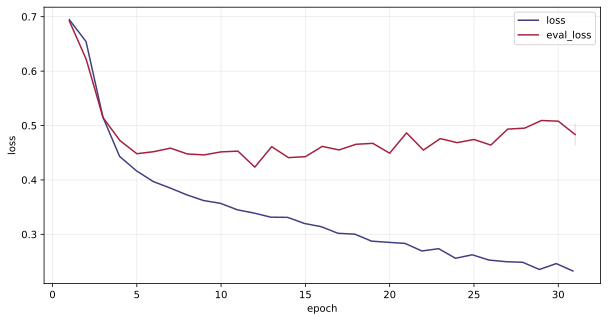

In [10]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=logs, x='epoch', y='loss', color=COLORS[0], label='loss', zorder=2)
sns.lineplot(data=logs, x='epoch', y='eval_loss', color=COLORS[1], label='eval_loss', zorder=2)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(alpha=0.25, zorder=0)
plt.legend()
plt.show();

In [11]:
# Error analysis

df = pd.DataFrame({'text': X_test.tolist(), 'true': y_true, 'pred': y_preds})
df['correct'] = df['true'] == df['pred']
df['correct'] = df['correct'].map({True: 'correct', False: 'incorrect'})
df['true'] = df['true'].map({0: 'ELL', 1: 'ENG'})
df['pred'] = df['pred'].map({0: 'ELL', 1: 'ENG'})
df

,text,true,pred,correct
0,well russia still had the means to be self sus...,ELL,ELL,correct
1,you are still labeling me and even going as fa...,ELL,ELL,correct
2,literally no news at all http://www.criirad.or...,ELL,ELL,correct
3,in the early 00 the greek army had revised som...,ELL,ELL,correct
4,his decisions to solely blame germany for ww0 ...,ELL,ENG,incorrect
...,...,...,...,...
1101,And that 's what I imagine the main motive beh...,ENG,ELL,incorrect
1102,This doesnt happen with male affection as its ...,ENG,ELL,incorrect
1103,In fact the biggest complaints in the UK are t...,ENG,ENG,correct
1104,"Sure but realistically , i can only work there...",ENG,ENG,correct


In [12]:
wrong_preds = df[df['correct'] == 'incorrect'] # only show incorrect predictions
wrong_preds

,text,true,pred,correct
4,his decisions to solely blame germany for ww0 ...,ELL,ENG,incorrect
6,make your self a favor and click the links per...,ELL,ENG,incorrect
7,they just conclude something without actually ...,ELL,ENG,incorrect
8,there is quite a lot that we need to prove or ...,ELL,ENG,incorrect
10,i dont think you understand the real problem u...,ELL,ENG,incorrect
...,...,...,...,...
1071,I do n't follow the banking situation the way ...,ENG,ELL,incorrect
1090,I think the western media were also spilling o...,ENG,ELL,incorrect
1097,"Nope , I have never seen that law before : / I...",ENG,ELL,incorrect
1101,And that 's what I imagine the main motive beh...,ENG,ELL,incorrect
